In [1]:
using Plots
using Polynomials

In [2]:
import Base: +,-,*,/,one

In [3]:
struct Spline
  X::AbstractArray{Float64}
  σ::AbstractArray{Poly{Float64}}
end

In [4]:
+(s₁::Spline,s₂::Spline) = Spline(s₁.X,[σ₁+σ₂ for (σ₁,σ₂) ∈ zip(s₁.σ,s₂.σ)])
-(s₁::Spline,s₂::Spline) = Spline(s₁.X,[σ₁-σ₂ for (σ₁,σ₂) ∈ zip(s₁.σ,s₂.σ)])
+(s₁::Spline,p) = Spline(s₁.X,[σ₁+p for σ₁ ∈ s₁.σ])

-(s::Spline,p) = Spline(s.X,[σ₁-p for σ₁ ∈ s.σ])
-(s::Spline) = Spline(s.X,[-σ₁ for σ₁ ∈ s.σ])

*(λ,s::Spline) = Spline(s.X,[λ*σ₁ for σ₁ ∈ s.σ])

(s::Spline)(t::Float64) = s.σ[min(findlast(s.X.≤t),length(s.σ))](t)
+(p,s::Spline) = s+p
*(s::Spline,λ) = λ*s

one(p::Poly) = typeof(p)([1],p.var) 
one(::Type{Poly}) = Poly{Float64}([1.0])

newton(X) = prod(Poly.([[x,-1] for x in X]))

newton (generic function with 1 method)

In [26]:
"""
Algorithm 1: construct a β-alternating sequence.

0. Initialisation

1. Find \\(t_i^-(\beta)\\) and \\(t_i^+(\beta)\\).
"""
function findAlternation(f::AbstractArray,β::Float64)
    t⁻ = Array{Int64,1}()
    t⁺ = Array{Int64,1}()
    M = max(maximum(f),-minimum(f))
    #if minimum(f) .≠ -M error("You need a function where max = -min") end
    append!(t⁻,findfirst(abs.(f) .≥ β*M))
    ε = sign(f[t⁻[1]])
    i = 1
    while true
        t = findfirst((-1)^(i-1)*ε.*f[t⁻[end]:end] .≤ -β*M)
        if !isnothing(t)
            append!(t⁻,t⁻[end] - 1 + t)
            append!(t⁺,t⁻[end-1] - 1 + findlast((-1)^(i-1)*ε.*f[t⁻[end-1]:t⁻[end]] .≥ β*M))
            i = i+1
        else
            break
        end
    end
        append!(t⁺,t⁻[end] - 1 + findlast((-1)^(i-1)*ε.*f[t⁻[end]:end] .≥ β*M))
    return (t⁻,t⁺)
end

findAlternation

In [6]:
function twoKnots(T::AbstractArray,f::Function,β⁻::AbstractFloat,β⁺::AbstractFloat,γ⁻::AbstractFloat,γ⁺::AbstractFloat,n::Integer)
    @assert 0 < β⁻ < β⁺ < 1
    @assert 0 < γ⁻ ≤ 1 < γ⁺
    a = T[1]; b=T[end]
    # Initialisation
    # σ = t -> ((t-a)/(b-a))*f(b) + ((t-b)/(a-b))*f(a)
    σ = Poly([-a,1])*f(b)/(b-a) + Poly([-b,1])*f(a)/(a-b)
    β = (β⁻ + β⁺)/2
    #β = rand(β⁻:(β⁺-β⁻)/1000:β⁺)
    # Main Step
    while true
        # Step 1
        M = maximum(σ.(T)-f.(T)); m = minimum(σ.(T)-f.(T))
        # Step 2: update σ
        σ -= (M+m)/2
        # Step 3 Apply Theorem 2.2 by constructing the β-alternating sequence
        (T⁻,T⁺) = findAlternation(σ.(T) - f.(T),β)
        (T⁻,T⁺) = (T[T⁻],T[T⁺])
        ε = sign((σ(T⁻[1])) - f(T⁻[1]))
        kβ = length(T⁻)
        # Step 4
        if kβ ≥ n+1 && β == β⁺ return σ end      # Stop: we have found a β⁺-approximation of the solution.
        # Step 5
        if kβ ≥ n+1 && β < β⁺ β = min(γ⁺*β,β⁺) end  # Update β
        # Step 6
        if kβ ≤ n
            ξ = [(t⁺+t⁻)/2 for (t⁺,t⁻) ∈ zip(T⁺[1:kβ-1],T⁻[2:kβ])]
            γ = ε*newton(ξ)
            # Construct the λ from the proof of Theorem 2.
            m₋ = minimum(abs.(γ.([t for t ∈ T for (t⁻,t⁺) ∈ zip(T⁻,T⁺) if t⁻ ≤ t ≤ t⁺ ])))
            m₊ = maximum(abs.(γ.(T)))
            λ = maximum(abs.(σ.(T)-f.(T)))*(1-β)/(m₋+m₊)
            σ = σ - λ*γ
            β = max(β⁻,γ⁻*β)
        end
    end
 end

twoKnots (generic function with 1 method)

In [7]:
"""
Algorithm 3: Construction of intermediary points \$\\xi_j\$
"""
function intermediary(T⁻::AbstractArray,T⁺::AbstractArray,X::AbstractArray,N::AbstractArray)
    r = zeros(Int,length(X)-1)
    J = [[] for _ ∈ N]
    S = []
    # Step j
    for j ∈ 1:length(T⁺)-1
        t⁺ = T⁺[j]
        t⁻ = T⁻[j+1]
        # Let i be such that t⁺ⱼ ∈[xᵢ,xᵢ₊₁).
        i = min(length(X)-1,findlast(X.≤t⁺))
        # We consider four cases.
        # First case: xᵢ≤t⁺ⱼ≤t⁻ⱼ₊₁≤xᵢ₊₁ and rᵢ<nᵢ
        if t⁻ ≤ X[i+1] && r[i]<N[i]+1
            ξ = (t⁺+t⁻)/2 # By construction ξ∈(xᵢ,xᵢ₊₁).
            r[i] = r[i]+1
            append!(J[i],ξ)
        end
        # Second case: xᵢ≤t⁺ⱼ<xᵢ₊₁≤t⁻ⱼ₊₁ and rᵢ<nᵢ
        if X[i+1] < t⁻ && r[i]<N[i]+1
            ξ = (t⁺+X[i+1])/2 # By construction ξ∈(xᵢ,xᵢ₊₁).
            r[i] = r[i]+1
            append!(J[i],ξ)   
        end
        # Third case: xᵢ≤t⁺ⱼ<xᵢ₊₁≤t⁻ⱼ₊₁ and rᵢ=nᵢ
        if X[i+1] < t⁻ && r[i]==N[i]+1
            ξ = (X[i+1]+min(t⁻,X[i+2]))/2 # By construction ξ∈(xᵢ₊₁,xᵢ₊₂).
            r[i+1] = 1 # This is necessarily the first interpolation point we add to that interval.
            J[i]=[ξ]
        end
        # Fourth case: xᵢ≤t⁺ⱼ≤t⁻ⱼ₊₁≤xᵢ₊₁ and rᵢ=nᵢ
        if t⁻ ≤ X[i+1] && r[i]==N[i]+1
            return nothing
        end
        append!(S,ξ)
    end
    return S
end

intermediary

In [8]:
function descentStep(γ,M::Float64,T::AbstractArray,T⁻::AbstractArray,T⁺::AbstractArray,β::Float64)
    m₋ = minimum(abs.(γ.([t for t ∈ T for (t⁻,t⁺) ∈ zip(T⁻,T⁺) if t⁻ ≤ t ≤ t⁺ ])))
    m₊ = maximum(abs.(γ.(T)))
    λ = M*(1-β)/(m₋+m₊)
    return λ
end

descentStep (generic function with 1 method)

In [9]:
"""
Construct a continuous spline with knots at X and interpolating the points at r:
"""
function spline(X::AbstractArray,R::AbstractArray)
    Γ = [newton(r for r ∈ R if x⁻≤r≤x⁺) for (x⁻,x⁺) ∈ zip(X[1:end-1],X[2:end])]
    σ = [Γ[1]]
    for (x,γ) ∈ zip(X[2:end],Γ[2:end])
        α = σ[end](x)/γ(x)
        push!(σ,α*γ)
    end
    return Spline(X,σ)
end

spline

In [63]:
"""
Algorithm 4: p+2 fixed knots
"""
function fixedKnots(f,X::AbstractArray,T::AbstractArray,N::AbstractArray,β::Float64)
    # Initialisation
    σ = Spline(X,[Poly([-x1,1])*f(x2)/(x2-x1) + Poly([-x2,1])*f(x1)/(x1-x2) for (x1,x2) ∈ zip(X[1:end-1],X[2:end])])
    λ = 0
    γ = 0*σ
    # Main step
    for _ = 1:20
        # Step 1
        M = maximum(σ.(T)-f.(T)); m = minimum(σ.(T)-f.(T))
        # Step 2: Update σ
        σ = σ - (M+m)/2
        # Step 3: Apply Theorem 2.2 to σ-f
        (T⁻,T⁺) = findAlternation(σ.(T) - f.(T),β)
        (T⁻,T⁺) = (T[T⁻],T[T⁺])
        ε = sign((σ(T⁻[1])) - f(T⁻[1]))
        kβ = length(T⁻)
        # Step 4: Apply Algorithm 3.
        ξ = intermediary(T⁻,T⁺,X,N)
        # Step 5: If Algorithm 3 stopped in the fourth iteration, stop. The spline is optimal.
        if isnothing(ξ) return (σ,0,0*σ) end
        # Step 6: otherwise, construct functions γ as in Prop. 3 and choose λ for a descent step.
        γ = ε*spline(X,ξ)
        λ = descentStep(γ,maximum(f.(T)-σ.(T)),T,T⁻,T⁺,β)
        σ = σ - λ*γ
    end
    return (σ,λ,γ)
end

fixedKnots

In [11]:
# Generate random function to approximate:
T = 0:0.001:1
ncos = 20
g = x->[cos(0.5*π*i*(x+0.5)) for i ∈ 1:ncos]
c = rand(ncos)
f = x -> sum(c.*g(x))

#43 (generic function with 1 method)

In [12]:
s=twoKnots(T,f,0.4,0.99,0.9,1.1,3)

Poly(0.47217781629074707 - 5.8718206110718505*x + 5.361499191545257*x^2)

In [32]:
function showDeviation(T,f,s,β)
    t⁻,t⁺ = findAlternation(s.(T)-f.(T),β)
    p1=plot(T,f.(T),label="\$f\$",framestyle=:origin)
    plot!(T,s.(T),label="\$\\sigma\$")
    scatter!(T[t⁻],f.(T[t⁻]),label="\$t^-\$")
    scatter!(T[t⁺],f.(T[t⁺]),label="\$t^-\$")

    d(t) = s(t)-f(t)
    p2=plot(T,d.(T),label="\$d\$",framestyle=:origin)
    scatter!(T[t⁻],d.(T[t⁻]),label="\$t^-\$")
    scatter!(T[t⁺],d.(T[t⁺]),label="\$t^+\$")
    
    return plot(p1,p2,layout=(2,1))
end

showDeviation (generic function with 1 method)

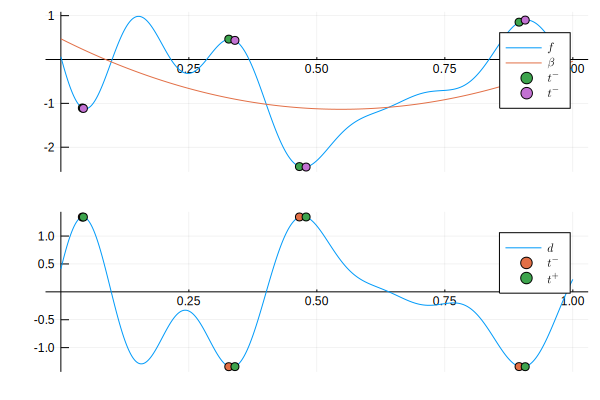

In [14]:
showDeviation(T,f,s,0.99)

In [64]:
β = 0.85
X = [0,0.3,0.7,1]
N = 2*ones(Int,length(X)-1)
(s,λ,γ) = fixedKnots(f,X,T,N,β)

(Spline([0.0, 0.3, 0.7, 1.0], Poly{Float64}[Poly(-0.476325 + 4.73833*x - 5.31044*x^2), Poly(10.8593 - 48.8021*x + 47.2065*x^2), Poly(-1.40038 + 1.75619*x)]), 0.5652675603584638, Spline([0.0, 0.3, 0.7, 1.0], Poly{Float64}[Poly(0.099 - 1.0*x), Poly(-1.55677 + 6.46158*x - 6.47452*x^2), Poly(-0.20618)]))

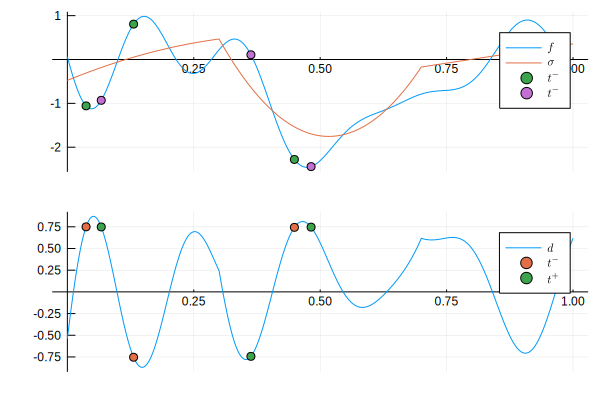

In [65]:
showDeviation(T,f,s,β)

In [66]:
#t⁻,t⁺ = findAlternation(s.(T)-f.(T),β)
p1=plot(T,f.(T),label="\$f\$",framestyle=:origin)
plot!(T,s.(T)+λ*γ.(T),label="\$\\sigma\$")
plot!(T,γ.(T),label="\$\\gamma\$")
plot!(T,s.(T),label="\$\\sigma + \\lambda\\gamma\$")
scatter!(T[t⁻],f.(T[t⁻]),label="\$t^-\$")
scatter!(T[t⁺],f.(T[t⁺]),label="\$t^+\$")

In [70]:
d(t) = s(t)+λ*γ(t)-f(t)
t⁻,t⁺ = findAlternation(d.(T),β)
p1=plot(T,d.(T),label="\$d\$",framestyle=:origin)
plot!(T,d.(T)-λ*γ.(T),label="\$d+ \\lambda\\gamma\$")
plot!(T,γ.(T),label="\$\\gamma\$")
scatter!(T[t⁻],d.(T[t⁻]),label="\$t^-\$")
scatter!(T[t⁺],d.(T[t⁺]),label="\$t^+\$")

In [73]:
maximum(d.(T))*β

0.7629328712806149

In [71]:
savefig("/tmp/deviation.tex")